In [23]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import random
import os
import copy
import time
import math
from math import sqrt

import matplotlib.pyplot as plt

In [2]:
def metric(y_test, y_hat, log=False):
    MSE  = mean_squared_error(y_test, y_hat)
    RMSE = sqrt(MSE)
    MAE  = mean_absolute_error(y_test, y_hat)
    MAPE = mean_absolute_percentage_error(y_test, y_hat)
    R2   = r2_score(y_test, y_hat)
    
    if log:
        print(f'\
MSE...............{MSE:.4f}\n\
RMSE..............{RMSE:.4f}\n\
MAE...............{MAE:.4f}\n\
MAPE..............{MAPE:.4f}\n\
R2................{R2:.4f}\
              ')
    
    return [MSE, RMSE, MAE, MAPE, R2]

In [3]:
def lagging_var(data, var, lags_list):
    lagged_df = data.copy()
    for name, lags in zip(var, lags_list):
        for lag in lags:
            if lag > 0: 
                lagged_df[name + '_L' + str(lag)] = lagged_df[name].shift(lag)
    lagged_df = lagged_df.fillna(0)
    return lagged_df

In [4]:
def unscale(data, dim, scaler):
    trainPredict_dataset_like = np.zeros(shape=(len(data), dim))
    trainPredict_dataset_like[:,0] = data[:,0]
    trainPredict = scaler.inverse_transform(trainPredict_dataset_like)[:,0]
    return trainPredict

In [5]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [10]:
# загрузка датасета
file_name = 'classification_data'

df = pd.read_pickle(f"DATASET\\{file_name}.pkl")
trg = df.pop('ats_price')
df

,node_price,workday,weekend,shortday,holiday,month,day,hour,day_of_week,year,index,load_planned_sobr,generate_planned_sobr,T2M
2019-09-15 00:00:00,596.798035,0.0,1.0,0.0,0.0,9.0,15.0,0.0,6.0,2019.0,67536.0,3314.781006,1855.880005,6.78
2019-09-15 01:00:00,596.328613,0.0,1.0,0.0,0.0,9.0,15.0,1.0,6.0,2019.0,67537.0,3299.569092,2000.879028,7.56
2019-09-15 02:00:00,594.732117,0.0,1.0,0.0,0.0,9.0,15.0,2.0,6.0,2019.0,67538.0,3342.320068,2000.879028,8.67
2019-09-15 03:00:00,590.206787,0.0,1.0,0.0,0.0,9.0,15.0,3.0,6.0,2019.0,67539.0,3368.802002,1855.880005,9.66
2019-09-15 04:00:00,721.414429,0.0,1.0,0.0,0.0,9.0,15.0,4.0,6.0,2019.0,67540.0,3534.553955,1886.124023,10.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01 19:00:00,1307.668457,1.0,0.0,0.0,0.0,8.0,1.0,19.0,0.0,2022.0,92779.0,3144.154053,2140.100098,14.07
2022-08-01 20:00:00,1285.128174,1.0,0.0,0.0,0.0,8.0,1.0,20.0,0.0,2022.0,92780.0,3053.440918,2140.100098,13.66
2022-08-01 21:00:00,1182.494141,1.0,0.0,0.0,0.0,8.0,1.0,21.0,0.0,2022.0,92781.0,3027.010010,2150.100098,13.30
2022-08-01 22:00:00,1084.094604,1.0,0.0,0.0,0.0,8.0,1.0,22.0,0.0,2022.0,92782.0,3027.762939,1847.401001,13.08


In [12]:
def data_prep(features, val_len=0.2, test_len=720, print_shapes=False):
    
    data = features.copy()
    y = pd.merge(trg, data.drop(columns=['node_price']), left_index=True, right_index=True)
    X = data.to_numpy()
    y = y.to_numpy()

    X_train_val = X[:len(X) - test_len]
    y_train_val = y[:len(y) - test_len]

    X_test      = X[len(X) - test_len:]
    y_test      = y[len(y) - test_len:]
    X_train     = X_train_val[:int(len(X_train_val)*(1-val_len))]
    y_train     = y_train_val[:int(len(y_train_val)*(1-val_len))]
    X_val       = X_train_val[int(len(X_train_val)*(1-val_len)):]
    y_val       = y_train_val[int(len(y_train_val)*(1-val_len)):]

    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    X_train, y_train = scaler.transform(X_train), scaler.transform(y_train)[:,0:1]
    X_val, y_val     = scaler.transform(X_val), scaler.transform(y_val)[:,0:1]
    X_test, y_test   = scaler.transform(X_test), scaler.transform(y_test)[:,0:1]
    
    feature_dim = X_train.shape[1]
    
    if print_shapes:
        print('Train data shape:')
        print(f'X_train -> {X_train.shape}')
        print(f'y_train -> {y_train.shape}')
        print('Val data shape:')
        print(f'X_val -> {X_val.shape}')
        print(f'y_val -> {y_val.shape}')
        print('Test data shape:')
        print(f'X_test -> {X_test.shape}')
        print(f'y_test -> {y_test.shape}')
        
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim

In [13]:
def eval_metrics(model, X_val, y_val, X_test, y_test, scaler, feature_dim,
                 iter_name=None, plot_val=False, plot_test=False, print_scores=False,
                 return_forecast=False):
    
    yhat = model.predict(X_val)
    yhat = unscale(yhat.reshape(-1,1), feature_dim, scaler)
    yact = unscale(y_val, feature_dim, scaler)

    if plot_test:
        plt.figure(figsize=(18,4))
        plt.plot(yhat, label='forecast')
        plt.plot(yact, label='actual')
        plt.title(f'VALIDATION {iter_name}')
        plt.legend()
        plt.show()

    metrics_val = metric(yact, yhat, log=print_scores)

    # # # #

    yhat = model.predict(X_test)
    yhat = unscale(yhat.reshape(-1,1), feature_dim, scaler)
    yact = unscale(y_test, feature_dim, scaler)
    
    if plot_test:
        plt.figure(figsize=(18,4))
        plt.plot(yhat, label='forecast')
        plt.plot(yact, label='actual')
        plt.title(f'TEST {iter_name}')
        plt.legend()
        plt.show()

    metrics_test = metric(yact, yhat, log=print_scores)
    
    if not return_forecast:
        return metrics_val, metrics_test
    else:
        return metrics_val, metrics_test, yact, yhat

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim = data_prep(features=df, 
                                                                                val_len=0.2, 
                                                                                test_len=720,  
                                                                                print_shapes=True)

Train data shape:
X_train -> (19564, 14)
y_train -> (19564, 1)
Val data shape:
X_val -> (4892, 14)
y_val -> (4892, 1)
Test data shape:
X_test -> (720, 14)
y_test -> (720, 1)


### Однократный запуск

Train data shape:
X_train -> (19564, 1)
y_train -> (19564, 1)
Val data shape:
X_val -> (4892, 1)
y_val -> (4892, 1)
Test data shape:
X_test -> (720, 1)
y_test -> (720, 1)


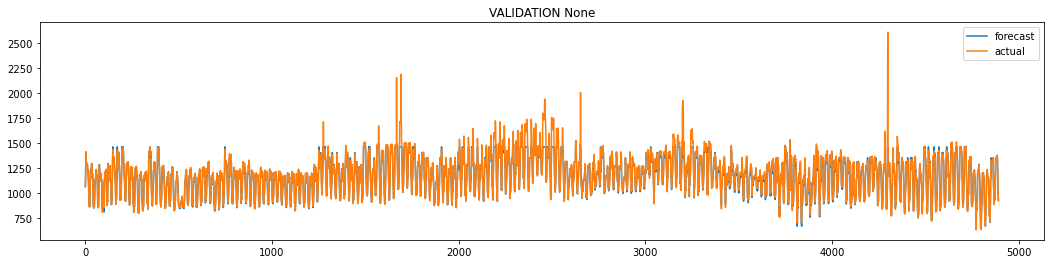

MSE...............2122.4885
RMSE..............46.0705
MAE...............17.2965
MAPE..............0.0129
R2................0.9442              


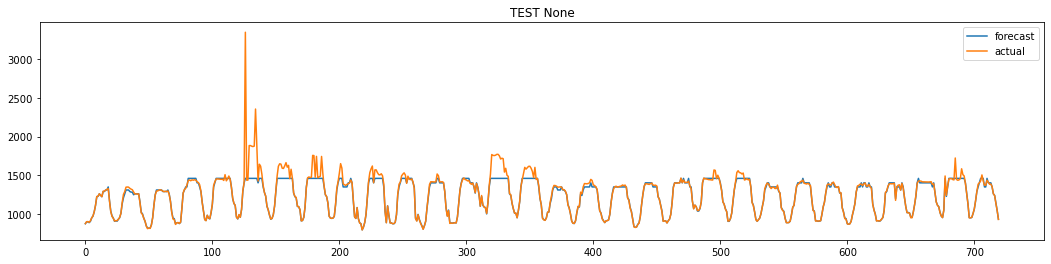

MSE...............10357.6803
RMSE..............101.7727
MAE...............29.8525
MAPE..............0.0181
R2................0.8347              


In [30]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim = data_prep(features=df[['node_price']], 
                                                                                val_len=0.2, 
                                                                                test_len=720,  
                                                                                print_shapes=True)

seed_everything(SEED)
params = {'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.03}
model = CatBoostRegressor(**params, verbose=False)
model.fit(X_train, y_train)

metrics_val, metrics_test, yact, yhat = eval_metrics(model, X_val, y_val, X_test, y_test, scaler, feature_dim,
                                                     iter_name=None, plot_val=True, plot_test=True, 
                                                     print_scores=True, return_forecast=True)

In [31]:
cat1day = pd.DataFrame({'yact' : yact, 'yhat' : yhat})
cat1day.to_pickle(f"DATASET\\cat1day.pkl")

### Итерировать по гиперпараметрам

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim = data_prep(features=df[['node_price']], 
                                                                                val_len=0.2, 
                                                                                test_len=720,  
                                                                                print_shapes=True)
seed_everything(SEED)

model = CatBoostRegressor(verbose=False)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

Train data shape:
X_train -> (19564, 1)
y_train -> (19564, 1)
Val data shape:
X_val -> (4892, 1)
y_val -> (4892, 1)
Test data shape:
X_test -> (720, 1)
y_test -> (720, 1)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.01885264684
bestIteration = 896

0:	loss: 0.0188526	best: 0.0188526 (0)	total: 2.46s	remaining: 1m 11s

bestTest = 0.01886954092
bestIteration = 620

1:	loss: 0.0188695	best: 0.0188526 (0)	total: 5.11s	remaining: 1m 11s

bestTest = 0.01885544853
bestIteration = 996

2:	loss: 0.0188554	best: 0.0188526 (0)	total: 7.65s	remaining: 1m 8s

bestTest = 0.01886700116
bestIteration = 630

3:	loss: 0.0188670	best: 0.0188526 (0)	total: 10.1s	remaining: 1m 5s

bestTest = 0.01885310575
bestIteration = 896

4:	loss: 0.0188531	best: 0.0188526 (0)	total: 12.6s	remaining: 1m 2s

bestTest = 0.0188693222
bestIteration = 634

5:	loss: 0.0188693	best: 0.0188526 (0)	total: 15.1s	remaining: 1m

bestTest = 0.0188662929
bestIteration = 982

6:	loss: 0.0188663	best: 0.0188526 (0)	total: 17.8s	remaining: 58.4s

bestTest = 0.0188685998
bestIteration = 640

7:	loss: 0.0188686	best: 0.0188526 (0)	total: 20.2s	remaining: 55.6s

bestTest = 0.01886813178
bestIteration = 999

8:	loss: 0.0188681	best: 0.01

In [29]:
grid_search_result

{'params': {'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

### Feature selection

In [20]:
np.set_printoptions(formatter={'float_kind' : "{:.3f}".format})

def train_model(data):
    print(f'\n{data.columns=}')
    
    X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim = data_prep(features=data, 
                                                                                    val_len=0.2, 
                                                                                    test_len=720,  
                                                                                    print_shapes=False)

    seed_everything(SEED)

    model = CatBoostRegressor(verbose=False)
    model.fit(X_train, y_train)

    metrics_val, metrics_test, yact, yhat = eval_metrics(model, X_val, y_val, X_test, y_test, scaler, feature_dim,
                                                         iter_name=None, plot_val=False, plot_test=False, 
                                                         print_scores=False, return_forecast=True)

    return model, metrics_val

def iterate(data):
    score = {}
    for i in main_features.columns:
        X = data.copy()
        X[i] = main_features[[i]]
        _, metrics = train_model(X)
        score.update({i : metrics[1]})
        results.loc[' + '.join(data.columns.tolist()), i] = metrics[1]
        print(f'....{i} -> RMSE={metrics[1]:.2f}')
    feature = min(score, key=score.get)
    print(f'Best feature - {feature}, metric improvment - {(score[feature]-prev_score):.3f} (acc = {score[feature]:.3f})')
    return feature, score[feature]

In [21]:
import warnings
warnings.filterwarnings('ignore')

main_features = df.copy()
data = pd.DataFrame(main_features.pop('node_price'))
_, init_score = train_model(data)
init_score = init_score[1]
prev_score = init_score
print(f'Initial score = {prev_score:.3f}')

results = pd.DataFrame()
results.loc[' + '.join(data.columns.tolist()), ' + '.join(data.columns.tolist())] = prev_score
epoch = len(main_features.columns)
hold = 0
for f in range(1,epoch+1):
    start = time.time()
    best_feature, best_score = iterate(data)
    if best_score < prev_score:
        hold = 0
        data[best_feature] = main_features.pop(best_feature)
        prev_score = best_score
        best_x = data.copy()
        print(f'add - {best_feature}\n')
    elif hold < 0:
        hold += 1
        data[best_feature] = main_features.pop(best_feature)
        print(f'negative add - {best_feature}\n')
    else:
        break
print('Picked features ->', [c for c in best_x.columns], '\n')
# # # # # # # # # # # # # # # # # # # # # #

_, metrics = train_model(best_x)

print(metrics)


data.columns=Index(['node_price'], dtype='object')
Initial score = 46.067

data.columns=Index(['node_price', 'workday'], dtype='object')
....workday -> RMSE=47.01

data.columns=Index(['node_price', 'weekend'], dtype='object')
....weekend -> RMSE=47.05

data.columns=Index(['node_price', 'shortday'], dtype='object')
....shortday -> RMSE=46.09

data.columns=Index(['node_price', 'holiday'], dtype='object')
....holiday -> RMSE=46.13

data.columns=Index(['node_price', 'month'], dtype='object')
....month -> RMSE=49.72

data.columns=Index(['node_price', 'day'], dtype='object')
....day -> RMSE=47.27

data.columns=Index(['node_price', 'hour'], dtype='object')
....hour -> RMSE=46.72

data.columns=Index(['node_price', 'day_of_week'], dtype='object')
....day_of_week -> RMSE=47.06

data.columns=Index(['node_price', 'year'], dtype='object')
....year -> RMSE=46.50

data.columns=Index(['node_price', 'index'], dtype='object')
....index -> RMSE=46.61

data.columns=Index(['node_price', 'load_planned_sobr

NameError: name 'best_x' is not defined

<AxesSubplot:>

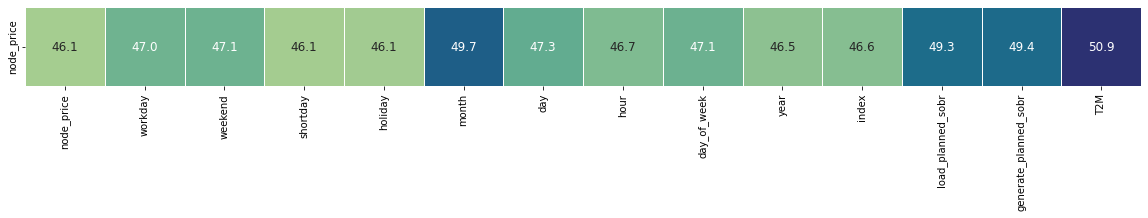

In [22]:
import seaborn as sns

plt.figure(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(results, cmap=cmap, square=True, linewidths=.5, cbar=False, annot=True, fmt=".1f", annot_kws={"size":12})